# Import packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics  import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

from CV_utils import cv_regressor
from plot_utils import *
from RegressionModels import ClusterElasticNet, GroupLasso

from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# Open preprocessed phenotype and kinase specificity matrix

In [2]:
# plt.scatter(X["FYN"], X["YES_YES1"])
# plt.plot(X["FYN"], X["FYN"], c="black")

In [3]:
### import drugs' charachteristics such as dose, label, name
path = './data/'

drug_phenotype_df = pd.read_csv(path + 'drug_phenotype_data.csv') 
drug_doses  = drug_phenotype_df['dose (uM)']
drug_labels = drug_phenotype_df['dose (label)']
drug_names = drug_phenotype_df['drugShortNames']

kinase_df = pd.read_csv(path + 'kinase_data.csv')
phenotype = pd.read_csv(path + 'y_plateau_preprocessed.csv')

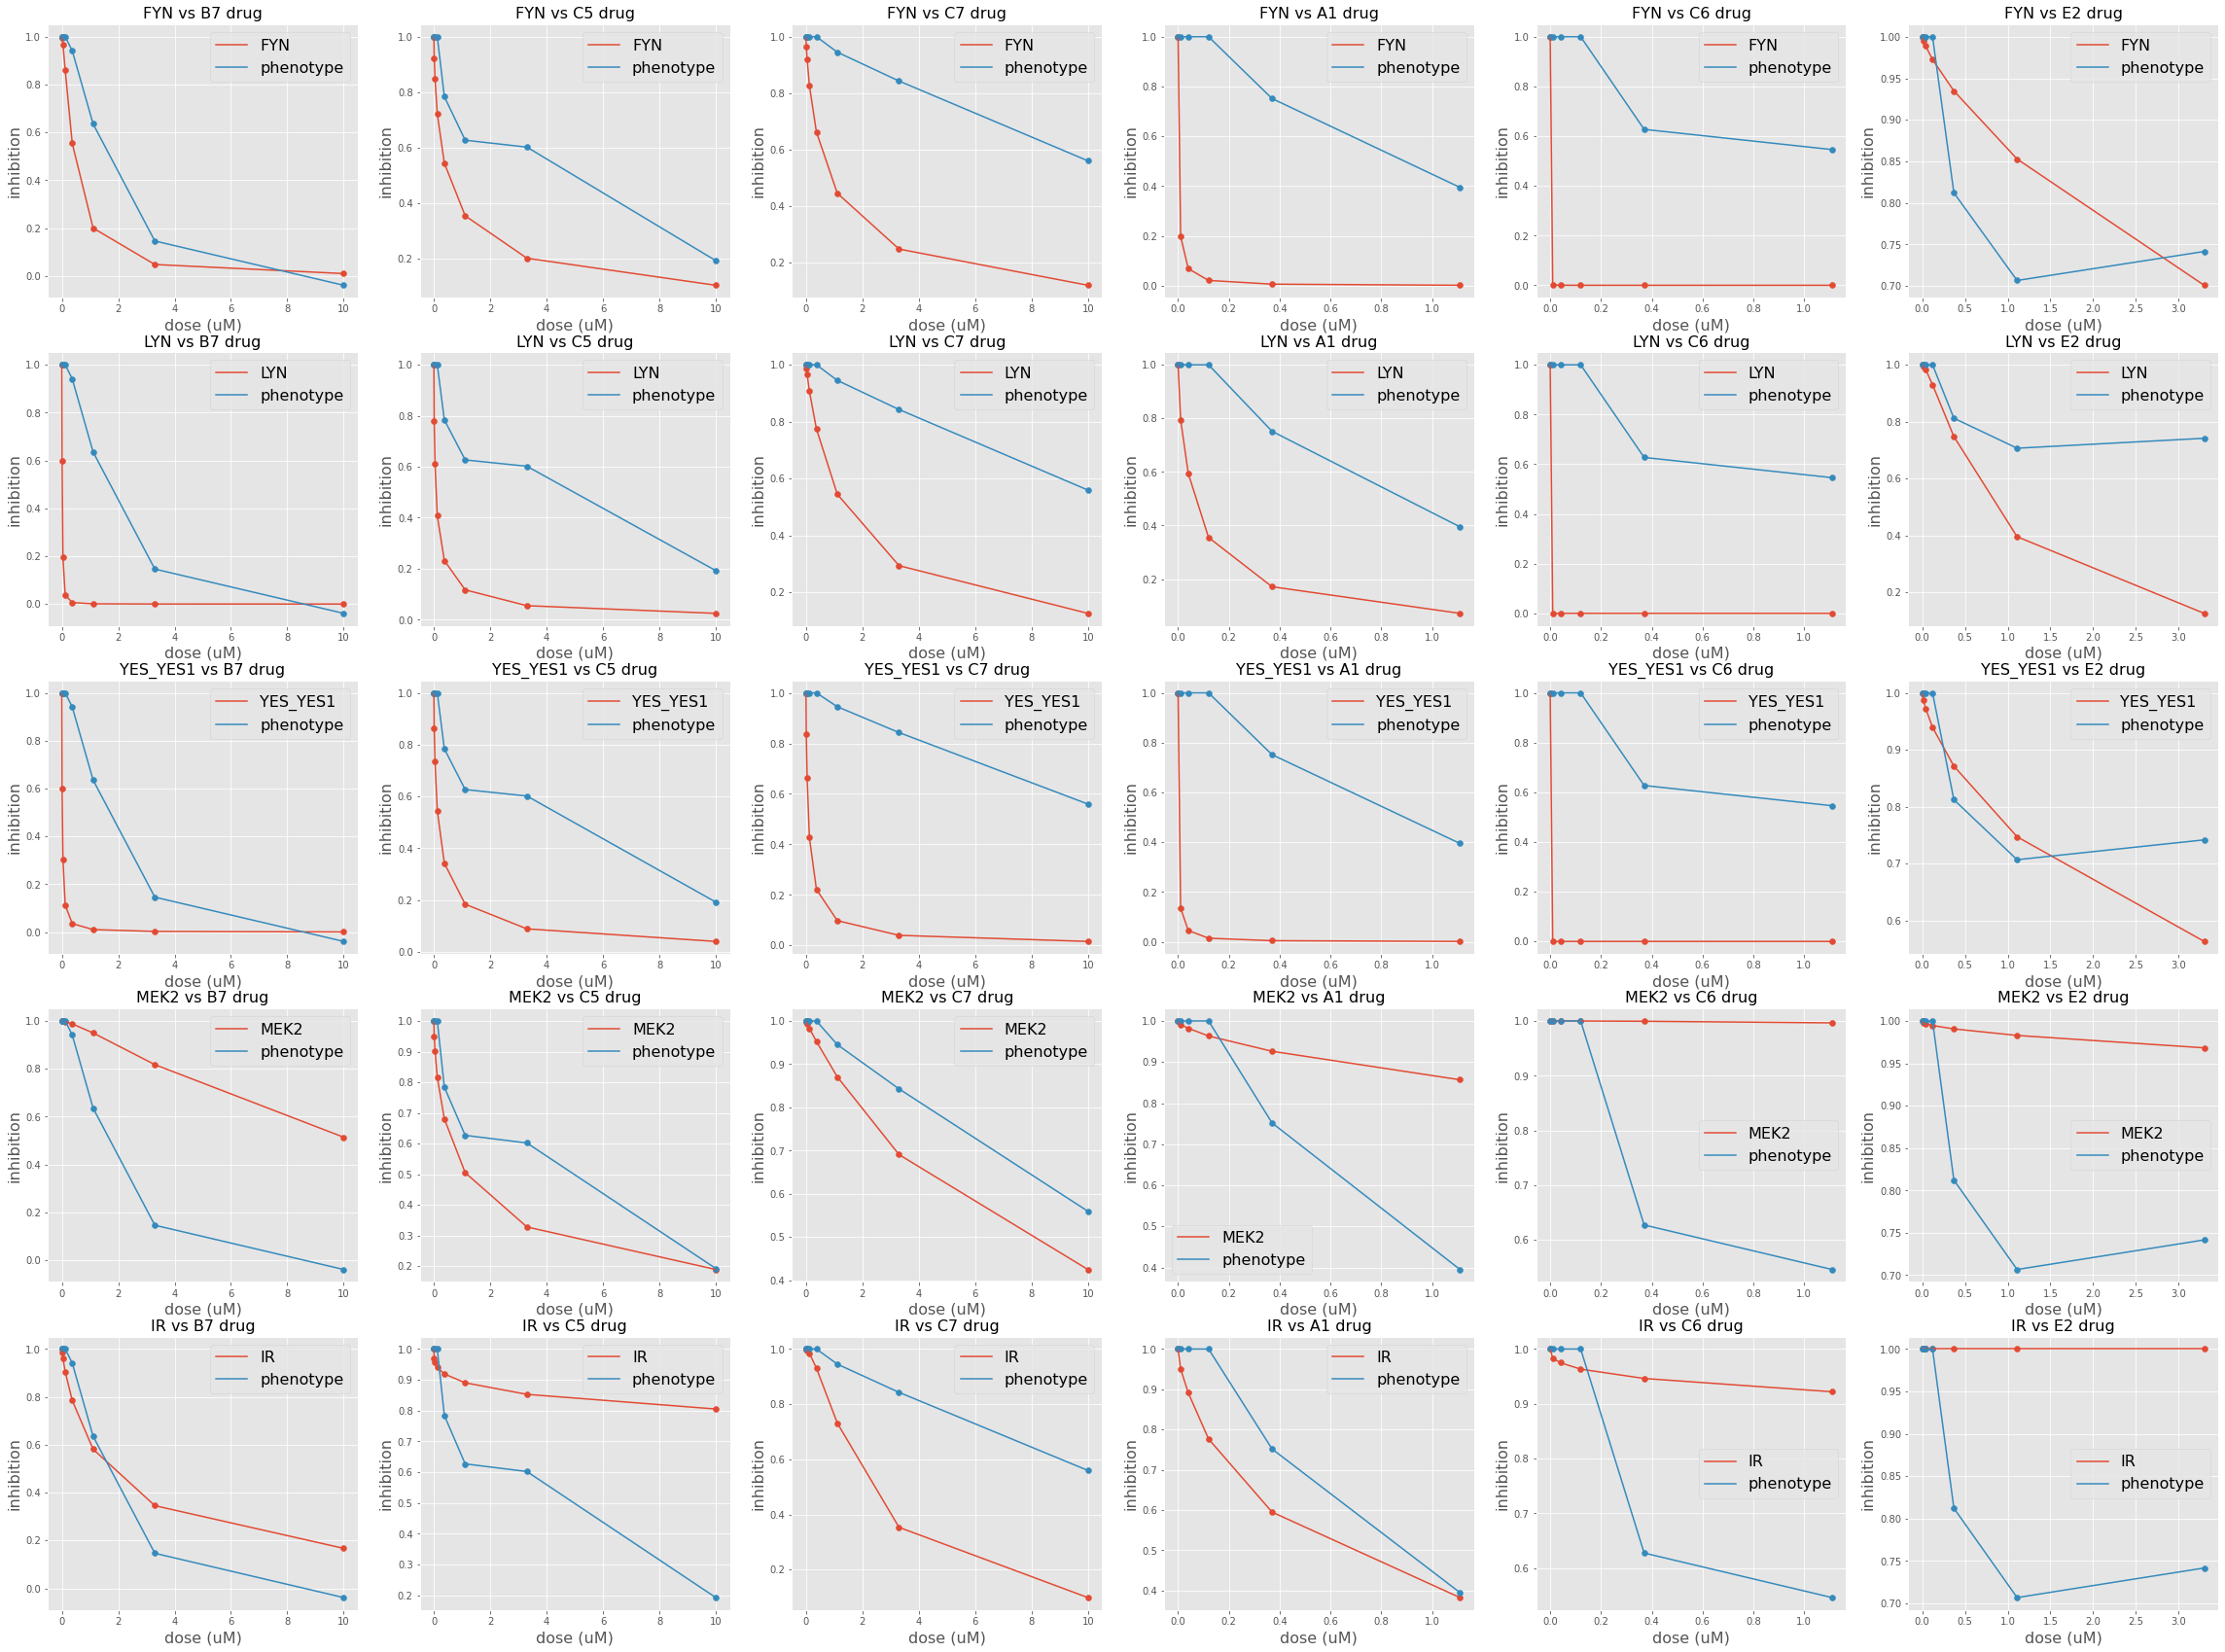

In [8]:
y_scaled = phenotype / 0.7
drugs_2_show = ["B7", "C5", "C7", "A1", "C6", "E2"]
kinases_2_show = ["FYN", "LYN", "YES_YES1", "MEK2", "IR"]

fig, axs = plt.subplots(len(kinases_2_show), len(drugs_2_show), figsize=(40, 30))

for i, kinase in enumerate(kinases_2_show):
    for j, drug in enumerate(drugs_2_show):
        drug_mask = drug_names == drug
        doses = drug_doses[drug_mask]   
        axs[i, j].plot(doses, kinase_df[kinase][drug_mask], label=kinase)
        axs[i, j].scatter(doses, kinase_df[kinase][drug_mask])
        axs[i, j].plot(doses, y_scaled[drug_mask], label="phenotype")
        axs[i, j].scatter(doses, y_scaled[drug_mask])
        
        axs[i, j].set_title(f"{kinase} vs {drug} drug", fontsize=16)
        axs[i, j].legend(fontsize=16) 
        axs[i, j].set_xlabel("dose (uM)", fontsize=16)
        axs[i, j].set_ylabel("inhibition", fontsize=16)
plt.savefig("kinase_vs_dose_plots.pdf", dpi=100)

  

In [5]:
# mask with good doses
not_specific_drugs = ["C4", "F6", "D4"]
final_mask = pd.read_csv(path + 'good_doses_mask.csv')['if_used_in_final'].values & \
             drug_names.apply(lambda x: x not in not_specific_drugs)


# additionally throw out all plateau points except for the last one (highest dose when phenotype=0.7) 
#for each drug.

# one_point_mask = pd.read_csv(path + "final_mask_1_point_on_plateau.csv")['if_used_in_final'].values
# final_mask = one_point_mask & final_mask

###check
assert len(kinase_df) == len(phenotype) == len(final_mask)

X = kinase_df[final_mask]

X_scaled = pd.DataFrame(StandardScaler(with_mean=True).fit_transform(X), columns=X.columns, index=X.index)

y = phenotype['Y'][final_mask]

y_drug_names = drug_names[final_mask]
y_drug_doses = drug_doses[final_mask]

print(f'After preprocessing we are left with {y_drug_names.nunique()} drugs, {final_mask.sum()} overall doses.')

After preprocessing we are left with 44 drugs, 312 overall doses.


In [13]:
# %matplotlib inline
# plot_each_col_X_vs_y(X, y, num_cols=5, figsize=(30,200))

# Linear Regression fitting with LODOCV 

To evaluate the perfomance of our model we use LODOCV (Leave-One-Drug-Out-Cross-Validation). Sequentially we throw out each drug in all its doses from the dataset, train our model on the remaining drugs, and test the model performance on the deleted drug. On each iteration we note correlation between predicted and true phenotypes and finally take the average of these results. The obtained number defines the quality of a given model. We avoid using standard Leave-One-Out-Cross-Validataion (LOOCV) because of high correlation between kinase specificities corresponding to the doses of one drug. Due to this fact, predicting a phenotype for one dose of a drug while having another dose in a training sample turned out to be an easy task for a model making the LOOCV a non-instructive metric for our problem.

In [34]:
# pca = PCA(318)
# pca.fit(X)
# %matplotlib inline
# plt.plot(np.cumsum(pca.explained_variance_ratio_))

# X_pca = pd.DataFrame(PCA(40).fit_transform(X), index=X.index)

In [12]:
# regularization parameter alpha should be tuned, l1_ratio is less importnat though also can be tuned

# sample_weight = y.apply(lambda x: np.exp(-(x - 0.2) ** 2))
sample_weight = y.apply(lambda x: (0.8 - x) ** 2)

net = ElasticNet(alpha=0.005, l1_ratio=0.5)
res_dict, y_pred, kinase_2_importance = cv_regressor(net, X_scaled, y, y_drug_names, sample_weight=None, 
                                                     metric=mean_absolute_error)

print(res_dict)

y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values

%pylab
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

{'r2': 0.581, 'cor': 0.763, 'train': 0.027, 'test': 0.051}
Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [92]:
# abs(X.corr()["FYN"]).sort_values()[-10:]

In [6]:
from Ensembler import UnivariateEnsembler
from InverseLinearRegression import InverseUnivariateLinearRegression

In [102]:
inv_reg = InverseUnivariateLinearRegression()
ens = UnivariateEnsembler(inv_reg, top_features=50)

In [103]:
fit_kwargs = {"feature_importance_extractor": lambda est: abs(est.coef_[0]),
             "sample_weight": sample_weight}

In [104]:
res_dict, y_pred, kinase_2_importance = cv_regressor(ens, X_scaled, y, y_drug_names, 
                                                     metric=mean_absolute_error, **fit_kwargs)

In [105]:
print(res_dict)

{'r2': 0.313, 'cor': 0.715, 'train': 0.077, 'test': 0.078}


# Visualization

In [106]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values

%pylab
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [14]:
### see the dict of importances
# kinase_2_importance 

In [29]:
## The same function can be used to visualize kinase inhibition vs phenotype
## You can click on each point and see what dose and drug in corresponds to

y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(X["FYN"], y, y_points_names, y_drug_names, if_plot_diag_line=False, lims=(-0.1, 1.1))

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [248]:
### List of 6 kinases which were proved to be responsible for the phenotype is highly correlated, so 
### we do not expect all of them to appear in the list of important kinases.

# interesting_kinases = ["FYN", "LYN", "EPHB2", "MINK_MINK1", "YES_YES1", "LATS2"]
# kinase_df[interesting_kinases].corr()

# Separate kinases into groups

## 0. KMeans

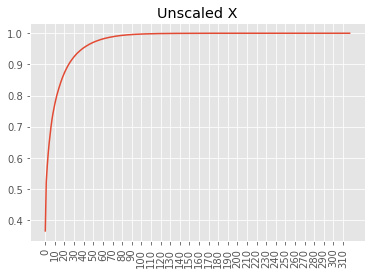

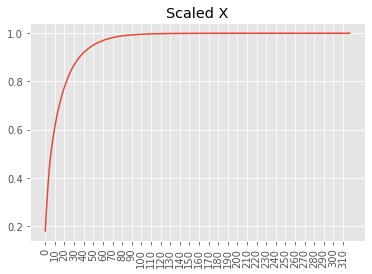

In [22]:
pca = PCA(min(X.shape))
pca.fit_transform(X.T)

%matplotlib inline
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Unscaled X")
# plt.hlines(0.9, 0, min(X.shape), linestyles="dashed", color="blue")
plt.xticks(range(0, min(X.shape), 10), rotation=90)
plt.show()

pca = PCA(25)
X_drug_feat_pca = pd.DataFrame(pca.fit_transform(X.T))

%matplotlib inline
pca = PCA(min(X_scaled.shape))
pca.fit_transform(X_scaled.T)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Scaled X")
# plt.hlines(0.9, 0, min(X.shape), linestyles="dashed", color="blue")
plt.xticks(range(0, min(X_scaled.shape), 10), rotation=90)
plt.show()

pca = PCA(40)
X_scaled_drug_feat_pca = pd.DataFrame(pca.fit_transform(X_scaled.T))

In [549]:
cluster_range = range(2, 200)
inertias = []
for n_clusters in tqdm(cluster_range):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(X_drug_feat_pca)
    inertias.append(kmeans.inertia_)
    

100%|█████████████████████████████████████████| 198/198 [00:37<00:00,  5.32it/s]


(369, 25)


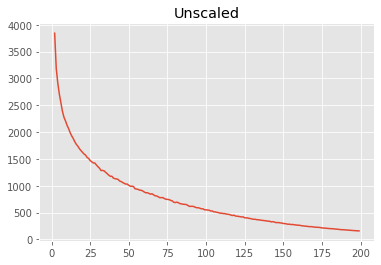

In [551]:
print(X_drug_feat_pca.shape)
%matplotlib inline
plt.plot(cluster_range, inertias)
plt.title("Unscaled")
plt.show()

### Scaled showed siilar results

## 1. Cluster Elastic Net (CEN)

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4011669/

X_1 ~ X_2 => X_1 beta_1 ~ X_2 beta_2

In [6]:
model_kwargs = {"n_clusters": 25, "lambda1": 1e-3, "lambda2": 1e-3, 
              "max_iter": 30, "tol": 1e-3, 
               "weight_update": "full"}

CEN = ClusterElasticNet(**model_kwargs)

In [11]:
CEN.fit(X,y, verbose=False)

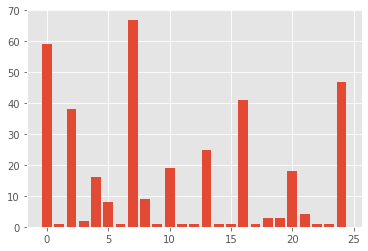

In [10]:
%matplotlib inline
cluster_counter = Counter(CEN.labels_)
plt.bar(cluster_counter.keys(), cluster_counter.values())
plt.show()

In [15]:
# cluster_2_max_weight = print_cluster_report(CEN, CEN.labels_)

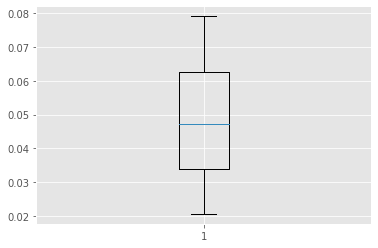

In [64]:
%matplotlib inline
plt.boxplot(cluster_2_max_weight.values())
plt.show()

In [16]:
res_dict, y_pred, kinase_2_importance = CV_regressor(CEN, X, y, y_drug_names, 
                                                     fit_kwargs={"verbose": False})

In [52]:
print(res_dict)

{'r2': 0.358, 'cor': 0.642, 'train': 0.025, 'test': 0.065}


In [53]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


## 2. Group Lasso with Pre-clustering

### Family clustering using Kinome tree

In [17]:
families_df = pd.read_excel("KIR3KinaseCategories.xlsx")["Category"]
families_2_index = {family: index + 1 for index, family in enumerate(families_df.unique())}
index_2_family = {index: family for family, index in families_2_index.items()}
families_indices = families_df.apply(lambda x: families_2_index[x])

In [106]:
lasso_kwargs={"group_index": families_indices, "alpha": 0.2, "lambda1": 1e-2}
group_lasso_family = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso_family, X_scaled, y, y_drug_names)
print(res_dict)

{'r2': 0.517, 'cor': 0.721, 'train': 0.029, 'test': 0.057}


In [107]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [18]:
# print_cluster_report(group_lasso_family, families_df.values, features=X.columns)

### KMeans clustering

In [26]:
kmeans = KMeans(25).fit(X_drug_feat_pca)
kmeans_families = pd.Series(kmeans.labels_)

kmeans = KMeans(30).fit(X_scaled_drug_feat_pca)
kmeans_families_scaled = pd.Series(kmeans.labels_)

In [27]:
lasso_kwargs={"group_index": kmeans_families, "alpha": 0.5, "lambda1": 1e-3}
group_lasso = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso, X, y, y_drug_names)
print(res_dict)

{'r2': 0.448, 'cor': 0.683, 'train': 0.86, 'test': -1.2397942589482642e+29}


In [28]:
lasso_kwargs={"group_index": kmeans_families_scaled, "alpha": 0.5, "lambda1":  1e-2}
group_lasso_scaled = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso_scaled, X_scaled, y, y_drug_names)
print(res_dict)

{'r2': 0.508, 'cor': 0.713, 'train': 0.798, 'test': -8.427923923163706e+28}


In [81]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [29]:
group_lasso.fit(X_scaled, y)

In [19]:
# cluster_2_max_weight = print_cluster_report(group_lasso, kmeans_families_scaled, features=X.columns)

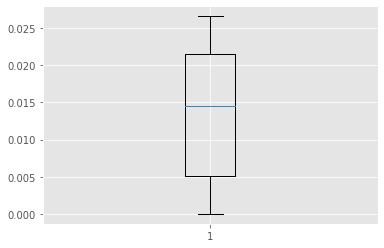

In [32]:
%matplotlib inline
plt.boxplot(cluster_2_max_weight.values())
plt.show()

### Graph clustering

In [12]:
from graph_utils import *

In [13]:
### Make Adjacency Dict
cor_matrix = X.corr()
kinase_2_correlated = make_kinase_2_correlated_neighbor_dict(cor_matrix, 0.9)

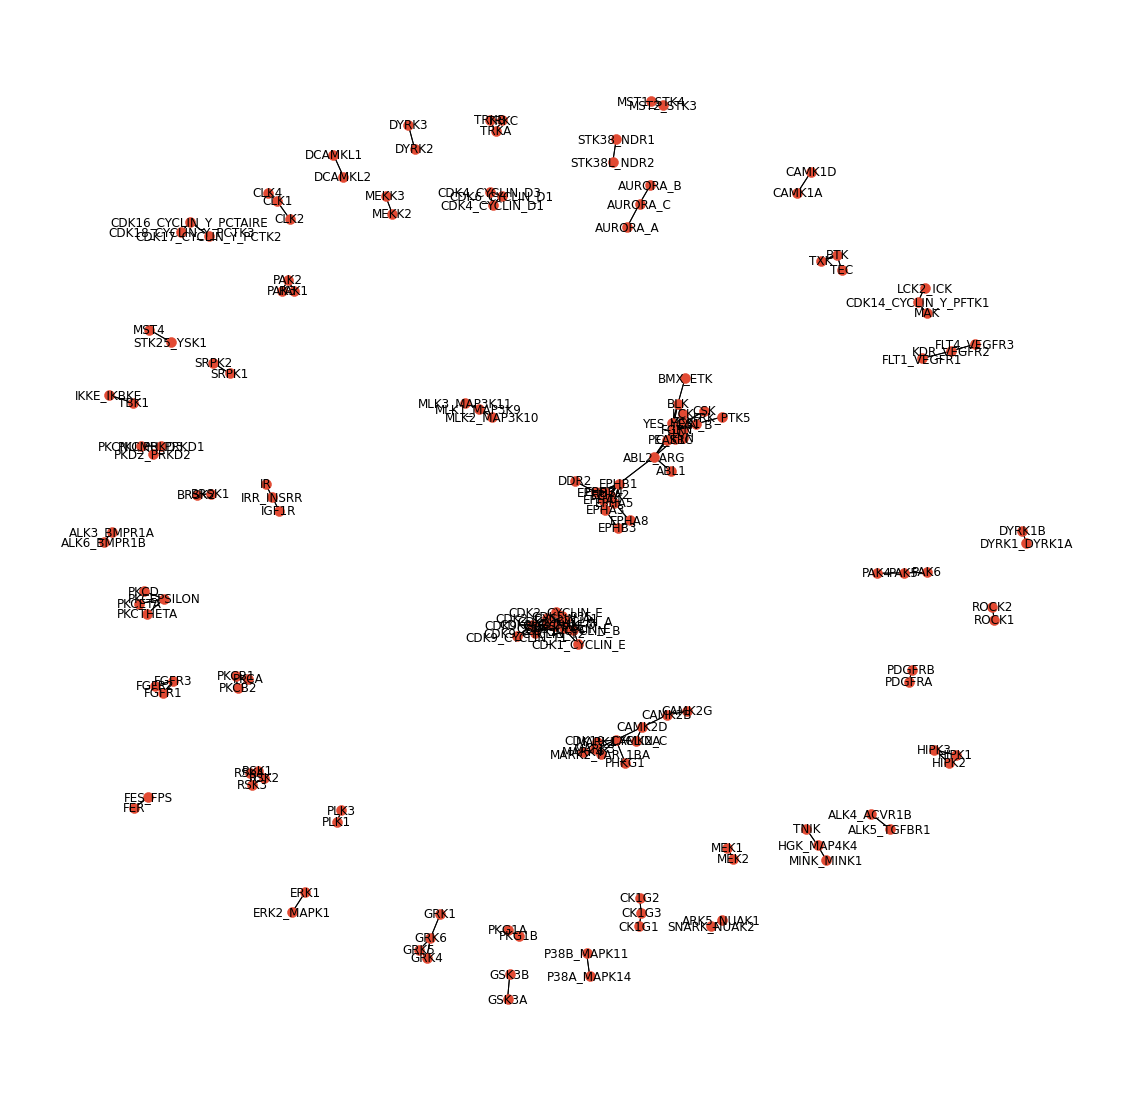

In [14]:
### Draw correlation graph
%matplotlib inline
draw_graph(kinase_2_correlated)

In [15]:
undirected_edges_list = make_undirected_edge_list(kinase_2_correlated)
    
graph = nx.Graph()
graph.add_edges_from(undirected_edges_list)

In [16]:
connected_components = list(nx.connected_components(graph))
print(f"Overall {len(connected_components)} connected components found in correlation graph")

Overall 47 connected components found in correlation graph


In [17]:
kinase_2_component = {}
for i, component in enumerate(connected_components):
    for kinase in component:
        kinase_2_component[kinase] = i + 1
                            
cur_group = len(connected_components)
for kinase in X.columns:
    if kinase not in kinase_2_component.keys():
        kinase_2_component[kinase] = cur_group
        cur_group += 1

In [18]:
group_index = pd.Series(X.columns).apply(lambda x: kinase_2_component[x])

In [21]:
lasso_kwargs={"group_index": group_index.values, "alpha": 0.5, "lambda1": 0.5 * 1e-3}
group_lasso = GroupLasso(**lasso_kwargs)

res_dict, y_pred, kinase_2_importance = CV_regressor(group_lasso, X, y, y_drug_names)
print(res_dict)

{'r2': 0.412, 'cor': 0.677, 'train': 0.911, 'test': -1.3015478855169339e+29}


In [66]:
y_points_names = (y_drug_names.astype(str) + ' (' + y_drug_doses.astype(str) + ' uM)').values
plot_regressed_line(y, y_pred, y_points_names, y_drug_names=y_drug_names, if_color_points=True)

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [20]:
# for cluster in sorted(np.unique(group_index)):
    
#     mask = group_index == cluster
#     print(f"### {cluster} ###")
#     print({k: abs(round(w,4)) for k, w in zip(X.columns[mask], group_lasso.coef_[mask])})
#     print()